# 社群媒體分析LabStudy 2-第4組
## 專案主題：PTT對於Disney+的討論
成員：M092040020 陳佳伶、M094020038 李佳蓉、M104020011 王培碩、M104020013 黃威凱、M104020048 顏宏任、M104020029 邱承漢

## 大綱
+ 1. 動機與分析目的
+ 2. 分析方向及工具
+ 3. 基本資料介紹
+ 4. CKIP
    + 探索分析 - NER
    + NER 各實體的詞頻
    + 迪士尼相關貼文之NER詞頻
+ 5. SnowNLP
    + 計算情緒分數、繪製情緒分布盒狀圖及時間趨勢圖
    + 正面句子的用詞
    + 負面句子的用詞
+ 6. TF-IDF
    + 負面句子的用詞
    + 計算每篇文章的詞數
    + 計算tf-idf值
+ 7. Bigram
    + 繪製字詞關聯圖
    + 相關性最高的 15 個詞彙
    + 利用詞彙關係圖繪製相關性大於0.4的組合
    + 計算文章相似度
+ 8. 字詞分類
    + 計算情緒分數，將正負面文章分類
    + 選出正面、負面文章最高的20個字
+ 9. 將文章轉為 DTM
    + 模型訓練: logistic regression + cv tokenizer
    + 定義建模與畫圖的函數
+ 10. 比較不同模型和資料組合的訓練結果
    + Model Building : logistic regression
    + Model Building : SVC
    + Model Building : Random Forest
    + 預測結果探索
    + 比較不同模型的ROC
    + 結論

## 1.動機與分析目的
迪士尼於今年(2021)11月12日正式推出Disney+線上影音串流訂閱服務，為了瞭解網友對於迪士尼所推出的服務，因此我們針對PTT上網友討論Disney的正負面情緒及影音作品討論做出本次的研究及分析。

## 2.分析方向及工具
1. CKIP將文句進行斷行、移除特殊字元，並完成標註。
2. Snownlp計算情緒分數、繪製情緒分布盒狀圖及時間趨勢圖。
3. TF-IDF找出文章以及字詞間的關聯。
4. Bigram計算字詞組合出現次數，並且用來預測字詞。
5. 使用Bigram結果繪製字詞關聯圖。
6. 此資料集用什麼樣的模型預測，準確率會較高？

## 3.基本資料介紹
* 資料來源：文字平台收集PTT Gossip八卦板、EAseries歐美影集板
* 資料集：PTT_Disney+_articleMetaData.csv、PPT_Disney+_articleReviews.csv
* 關鍵字：Disney+、Disney、迪士尼、迪士尼+
* 資料時間：2021-10-01 ～ 2021-12-04
* 情緒字典：正負向字典採用NTUSD(台大)情緒字典
* 資料量： 411 篇文章、16,231 個留言

In [1]:
%pwd

'C:\\Users\\Ling Chen\\Documents\\social_media_analysis\\Disney_final'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw
import time
from datetime import datetime, timedelta
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

In [4]:
#匯入資料
MetaData = pd.read_csv('./raw_data/Disney_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/Disney_articleReviews.csv', encoding='UTF-8')

In [5]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 411 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...
1,[新聞]魔鬼大帝:真實謊言影集版卡司確定,2021/10/01,03:34:40,https://www.ptt.cc/bbs/EAseries/M.1633059283.A...,ariachiang,EAseries,6,4,0,這齣傳說已久、眾說紛紜、籌備與準備預定的頻道／平台跟製作班底不斷變化的經典動作\n喜劇電影的...
2,[新聞]快訊／Disney＋登台價格確定！9張電影票,2021/10/08,02:59:17,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,kylefan,EAseries,101,56,0,記者蕭采薇／台北報導\n\n華特迪士尼公司的線上影音串流服務「Disney+」將於11月12...


In [6]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(1)

共有 16231 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[新聞]魔鬼大帝:真實謊言影集版卡司確定,2021/10/01,03:34:40,https://www.ptt.cc/bbs/EAseries/M.1633059283.A...,ariachiang,EAseries,BW556,推,2021-10-01 18:43:00,:那時候潔美李寇蒂斯身材超辣的印象很深刻


In [7]:
# 再篩一次文章
keywords = ['Disney','Disney+','迪士尼','迪士尼+'] #'Disney' 'Disney+' '迪士尼' '迪士尼+'
toMatch = '|'.join(keywords)

In [8]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(395, 10)


In [9]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [10]:
print(Reviews.shape)
Reviews.head(1)

(14986, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,NaN


## 4.CKIP
將文句進行斷行、移除特殊字元，並完成標註。

In [11]:
#data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

In [12]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

C:\Users\Ling Chen\anaconda3\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
C:\Users\Ling Chen\anaconda3\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
C:\Users\Ling Chen\anaconda3\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
C:\Users\Ling Chen\anaconda3\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will 

In [13]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub('(新聞|網址|新聞來源|媒體來源|記者署名|完整新聞|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)','',clean_paragraph)
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
            clean_paragraph = re.sub('(http|https)://.*','',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result


#有特別加上移除新聞的清理

In [14]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['sentence']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list) # set dictionary  
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['artUrl'],sentence])            
            temp_tokens = get_pos(row['artUrl'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['artUrl'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['artUrl','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['artUrl','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['artUrl','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [15]:
#pos_table, entity_table, sentence_table = get_nlp_result(MetaData)
#time costing: 337.61016511917114

In [16]:
#pos_table.head(5) # word pos 列表

In [17]:
#entity_table.head(5) # word entity 列表

In [18]:
# 檢查筆數正不正確
#print(f"total posts numbers: {len(pos_table['artUrl'].unique())}") #
#print(f"posts have NER: {len(entity_table['artUrl'].unique())}") # 

In [19]:
# 將文章存成csv
#pos_table.to_csv(r'./raw_data/pos_table_disney.csv', index = False)
#entity_table.to_csv(r'./raw_data/entity_table_disney.csv', index = False)
#sentence_table.to_csv(r'./raw_data/sentence_table_disney.csv', index = False)

In [20]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("./raw_data/pos_table_disney.csv") 
entity_table = pd.read_csv("./raw_data/entity_table_disney.csv") 
sentence_table = pd.read_csv("./raw_data/sentence_table_disney.csv") 

In [21]:
entity_table['ner'].unique()

array(['DATE', 'ORDINAL', 'LANGUAGE', 'CARDINAL', 'GPE', 'LOC', 'ORG',
       'PERSON', 'PRODUCT', 'NORP', 'EVENT', 'WORK_OF_ART', 'TIME', 'FAC',
       'MONEY', 'PERCENT', 'QUANTITY'], dtype=object)

In [22]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
12,PERSON,1878
4,GPE,986
10,ORG,792
1,DATE,727
0,CARDINAL,605
9,ORDINAL,267
8,NORP,255
6,LOC,164
15,TIME,102
3,FAC,101


<ipython-input-23-f7561ccdfaca>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


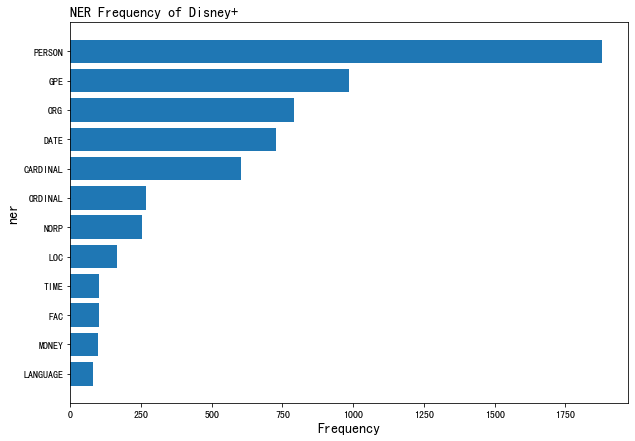

In [23]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of Disney+',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

在NER裡，我們可以看到詞頻最高的是PERSON，其次是GPE，接著是ORG，接著我們會一一呈現幾項詞頻較高的項目。

### NER 各實體的詞頻

**<font>NER - GPE</font>**

<ipython-input-24-2fa0524ae161>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


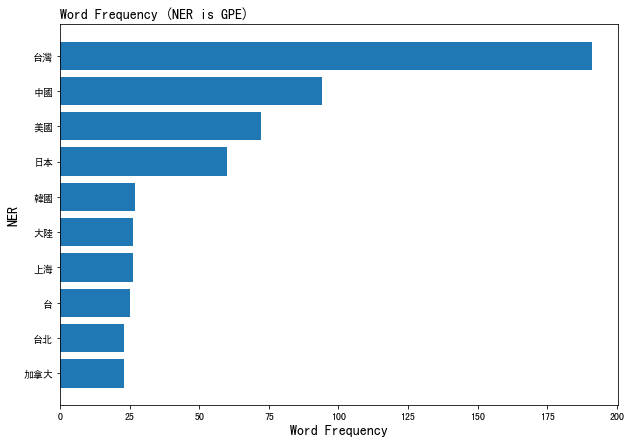

In [24]:
# 篩選ner為名詞的資料
l_noun = ["GPE"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is GPE)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

這邊我們可以從國家或地點的字頻分析中得知，**<font color=blue>「台灣 」</font>**在這個話題是被提及的次數最多，其次是「中國」、「美國」等。

**<font>NER - PERSON 涉及到的人名</font>**

<ipython-input-25-d1648746b793>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


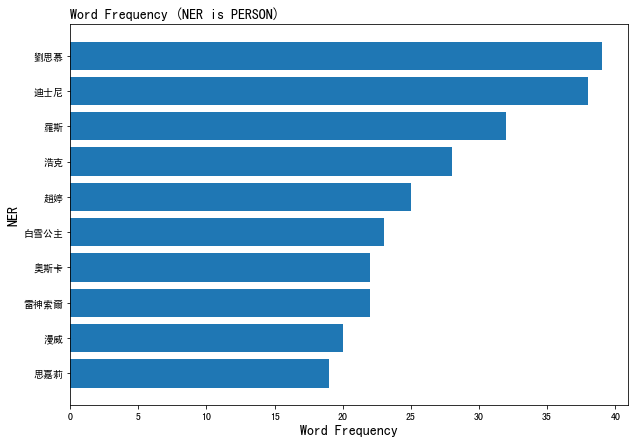

In [25]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

這邊比較特別的是人名詞頻最多的是**<font>「劉思慕」</font>**，我們去查找資料之後發現劉思慕飾演尚氣與十環傳奇的男主角被中國網民批說辱華。<br>
除此之外，我們會看到大多數人名詞頻較高的詞都是**<font>迪士尼中的角色或是迪士尼旗下漫威的電影角色名子</font>**。

### 迪士尼相關貼文之NER詞頻

In [26]:
keyword_list = ['迪士尼']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

迪士尼：353篇相關貼文


,artUrl,sentence
98,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,華特迪士尼公司的線上影音串流服務將於月日正式登台，屆時台灣將與
108,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,內容除了迪士尼近
114,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,內容除了迪士尼外，還包含皮克斯漫威星際大戰國家地理頻道和
139,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,華特迪士尼公司的線上影音串流服務
152,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,將在年月日正式上線，其中迪士尼皮克斯漫威星際大戰國家地
174,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,迪士尼經典電影和動畫
329,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,台灣觀眾可以在上欣賞來自迪士尼皮克斯漫威星際大戰國家地理及
335,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,除了來自迪士尼皮克斯漫威星際大戰國家地理及等六大牌龐大內容庫以外
337,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,/亞太區內容發布會中，華特迪士尼公司展示了一系列為打造的全球亞太
344,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,迪士尼的宏願是預計將於年前啟動至少部亞太區原創作品


**<font>NER - ORG 涉及到的組織</font>**

<ipython-input-27-e2400c288cbc>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


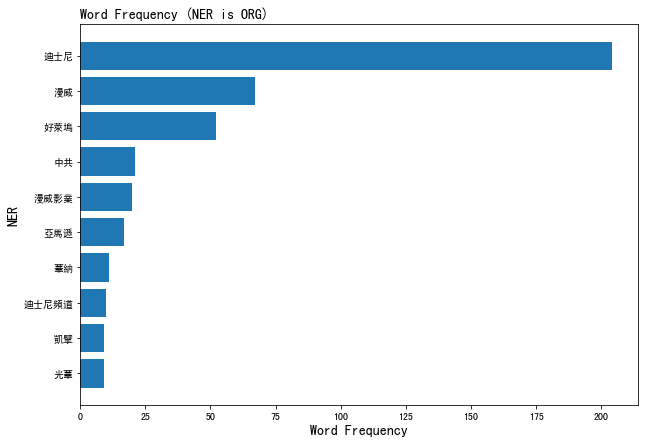

In [27]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [28]:
keyword_list = ['迪士尼']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(5)

迪士尼：353篇相關貼文


,artUrl,sentence
98,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,華特迪士尼公司的線上影音串流服務將於月日正式登台，屆時台灣將與
108,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,內容除了迪士尼近
114,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,內容除了迪士尼外，還包含皮克斯漫威星際大戰國家地理頻道和
139,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,華特迪士尼公司的線上影音串流服務
152,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,將在年月日正式上線，其中迪士尼皮克斯漫威星際大戰國家地


In [29]:
pos_table['pos'].unique()

array(['VCL', 'Nd', 'COMMACATEGORY', 'P', 'Na', 'DE', 'VHC', 'D', 'Nes',
       'V_2', 'Neu', 'Nf', 'VH', 'Ncd', 'VC', 'Cbb', 'VE', 'Ng', 'VJ',
       'VK', 'T', 'Neqa', 'Caa', 'Dfa', 'SHI', 'A', 'Nep', 'VB', 'FW',
       'Nc', 'VA', 'Nh', 'Di', 'Nb', 'Nv', 'Da', 'VF', 'VL', 'VG', 'Cab',
       'VD', 'VAC', 'Neqb', 'VI', 'Dfb', 'I', 'PERIODCATEGORY',
       'COLONCATEGORY', 'DM', 'Dk', 'Cba', 'PARENTHESISCATEGORY'],
      dtype=object)

In [30]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
15,Na,21368
5,D,10874
35,VC,6769
41,VH,6127
6,DE,5684
29,P,4181
17,Nc,3322
16,Nb,3130
25,Nf,2822
27,Nh,2629


**<font>NER 詞頻</font>**

<ipython-input-31-58472d1a927e>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


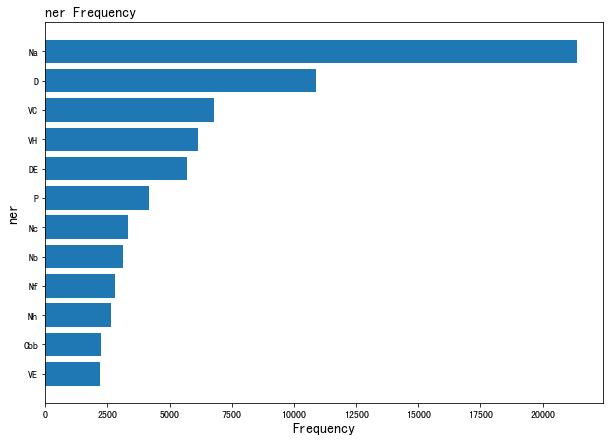

In [31]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

**<font>POS - Na涉及到的名詞</font>**

In [32]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"  #Nb為專有名詞
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
# 寫法一
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count.head(10)

,word,count
0,迪士尼,323
1,漫威,248
2,劉思慕,39
3,浩克,38
4,羅斯,32
5,奧斯卡,32
6,白雪公主,29
7,趙婷,26
8,思嘉莉,26
9,中共,25


<ipython-input-33-e273c993283c>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


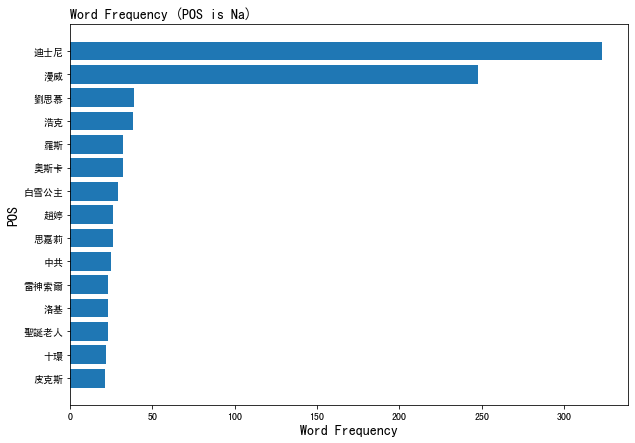

In [33]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is Na)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

**<font>POS - 涉及到的動詞(VERB)</font>**

In [34]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'] \
                                 .count() \
                                 .reset_index(name='count') \
                                 .sort_values(['count'], ascending=False) \
                                 .head(15)
verb_count

,word,count
1284,這樣,82
2,一樣,72
963,直接,67
269,合作,64
175,出現,63
227,原創,61
30,不同,50
893,特別,47
736,正式,43
989,知名,40


<ipython-input-35-d575e700e9d7>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


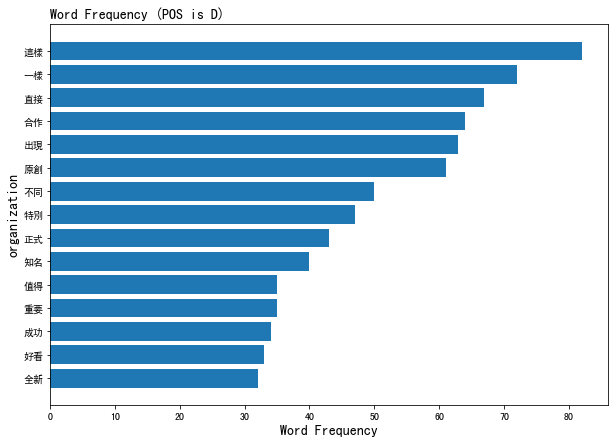

In [35]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is D)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [36]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['原創','好看','不錯']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

原創 好看 不錯：133篇相關貼文


,artUrl,sentence
4,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,在原創榜的部分，本周有新作推出新季及因為時機而進入前名的節目
9,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,以下是原創節目的統計結果
50,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,原創節目影集僅占了首尾兩位，也就是原創榜首與第二名兩齣影集
74,https://www.ptt.cc/bbs/EAseries/M.1633059283.A...,所預定的版本將由的原創與電影版導演共同
188,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,其他原創內容
196,https://www.ptt.cc/bbs/EAseries/M.1633692858.A...,原創今天新消息台灣會上架中文譯名破案三人行
209,https://www.ptt.cc/bbs/EAseries/M.1633796383.A...,九月第二周要名列前茅的重點很簡單，原創要新鮮集數，老劇靠人望
210,https://www.ptt.cc/bbs/EAseries/M.1633796383.A...,在原創的部分，或許是輸在號上下，距離統計結束日的時間不夠累積，因此
211,https://www.ptt.cc/bbs/EAseries/M.1633796383.A...,未能衝上原創節目榜首
248,https://www.ptt.cc/bbs/EAseries/M.1634229446.A...,原創節目


## 5.SnowNLP
計算情緒分數、繪製情緒分布盒狀圖及時間趨勢圖。

In [37]:
from snownlp import SnowNLP

In [38]:
sentence_table = pd.read_csv("./raw_data/sentence_table_disney.csv") #匯資料
metadata_df = MetaData.copy()#匯資料



sentiment_date = pd.merge(sentence_table,metadata_df[['artUrl','artDate','artCat']],on='artUrl',how='left')
sentiment_date.head(3)

,artUrl,sentence,artDate,artCat
0,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前之列,2021/10/01,EAseries
1,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,但的老闆有說後面明年初以後的檔期真受到疫情停工影響，或許偶爾會出現包括,2021/10/01,EAseries
2,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,新作在內的串流節目出現青黃不接的情況,2021/10/01,EAseries


In [39]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(5)

,artUrl,sentence,artDate,artCat,sentimentValue
0,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前之列,2021/10/01,EAseries,0.009056
1,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,但的老闆有說後面明年初以後的檔期真受到疫情停工影響，或許偶爾會出現包括,2021/10/01,EAseries,0.997103
2,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,新作在內的串流節目出現青黃不接的情況,2021/10/01,EAseries,0.645562
3,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,希望不會因為要趕上期程就隨便了,2021/10/01,EAseries,0.635300
4,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,在原創榜的部分，本周有新作推出新季及因為時機而進入前名的節目,2021/10/01,EAseries,0.003471


In [40]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe() # 2145句話

count    9.950000e+03
mean     4.667577e-01
std      3.386762e-01
min      1.594983e-07
25%      1.500466e-01
50%      4.549751e-01
75%      7.901114e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

### 情緒分布的盒狀圖

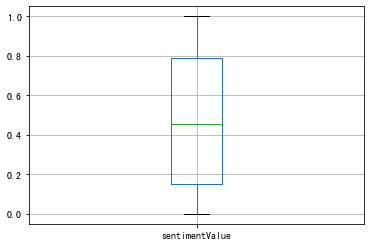

In [41]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

在情緒分布這邊，我們可以看到是略為小於0.5的，也就是代表著負向情緒是略為多一點的。

In [42]:
sentiment_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.date
sentiment_count = sentiment_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate,sentimentValue
0,2021-10-01,0.464552
1,2021-10-02,0.523294
2,2021-10-03,0.447589
3,2021-10-04,0.464812
4,2021-10-05,0.474361


### 平均情緒分數時間趨勢

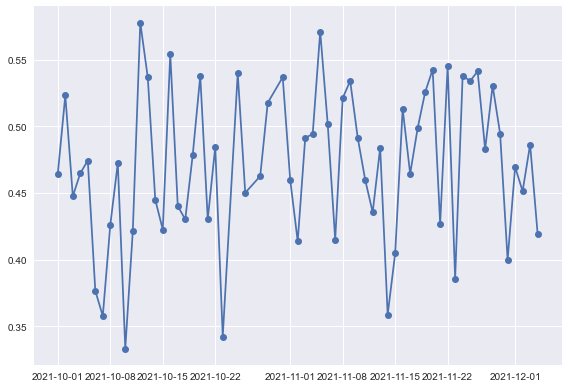

In [43]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.show()

從平均情緒分數與時間趨勢來看，剛開始的負向情緒是比較高的，接著慢慢地往正向情緒上升，不過我們也能從折線圖中看到，當一有負向情緒出現時會急遽增加。

In [44]:
# 篩出八卦板和歐美影集板
sentiment_date = sentiment_date[sentiment_date['artCat'].isin(['Gossiping', 'EAseries'])]
# 算每天的情緒
source_count = sentiment_date.groupby(['artDate','artCat'])['sentimentValue'].mean().reset_index()
source_count.head(5)

,artDate,artCat,sentimentValue
0,2021-10-01,EAseries,0.445398
1,2021-10-01,Gossiping,0.635593
2,2021-10-02,Gossiping,0.542672
3,2021-10-04,Gossiping,0.640484
4,2021-10-05,Gossiping,0.464923


In [45]:
# spread the column
source_pivot = source_count.pivot_table(index=['artDate'],columns='artCat',values='sentimentValue',fill_value=0).reset_index()
source_pivot.head()

artCat,artDate,EAseries,Gossiping
0,2021-10-01,0.445398,0.635593
1,2021-10-02,0.000000,0.542672
2,2021-10-04,0.000000,0.640484
3,2021-10-05,0.000000,0.464923
4,2021-10-06,0.000000,0.376628


### 比較不同板的情緒分數時間趨勢(八卦板vs歐美影集板)

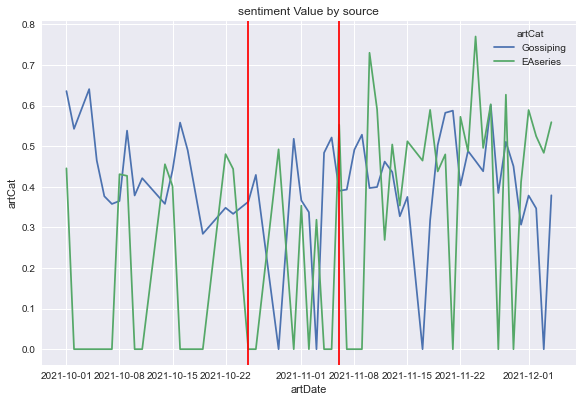

In [46]:
# 不同板情緒分數時間趨勢
plt.style.use('seaborn')

source_pivot.plot(x="artDate", y=["Gossiping", "EAseries"])
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.ylabel('sentiment Value')
plt.ylabel('artCat')
plt.title('sentiment Value by source')
plt.axvline(x=datetime.strptime('2021-10-25', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-11-06', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-30', "%Y-%m-%d"), color="red", ls="-")
plt.show()

由上方折線圖我們可以看到在**<font> 10/25~11/6 </font>**這段期間，不管是八卦板或是歐美板，都處於負向情緒較高的狀態。<br>
而其他時候則皆有高低之分，普遍來說整體情緒以**<font> 負向較正向多</font>**。<br>
另外，也可以看得出**<font>歐美影集板 </font>**的情緒波動在這段期間內比起八卦板來的大，推測有可能是受到影集劇情的影響而有較大的情緒起伏。

In [47]:
# 篩時間區間
startdate = pd.to_datetime("2021-10-25").date()
enddate = pd.to_datetime("2021-11-06").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.48]

# 看一下正面句子都在討論甚麼
filter_sentiment.head(5)

,artUrl,sentence,artDate,artCat,sentimentValue
467,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,的情景,2021-10-29,EAseries,0.640000
472,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,而九月第五周出現的新面孔則是重新打入前名的的律政巨人及的假如,2021-10-29,EAseries,0.959166
474,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,",",2021-10-29,EAseries,0.526233
476,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,",",2021-10-29,EAseries,0.526233
477,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,午夜彌撒,2021-10-29,EAseries,0.502176


In [48]:
# 把時間分數和之前斷詞的token table做 join
positive_words = pd.merge(filter_sentiment,pos_table,on='artUrl',how='left')
positive_words = positive_words[['artUrl','sentimentValue','word']]
positive_words.head(5)

,artUrl,sentimentValue,word
0,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,0.64,新
1,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,0.64,出爐
2,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,0.64,的
3,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,0.64,九月
4,https://www.ptt.cc/bbs/EAseries/M.1635474467.A...,0.64,最後


In [49]:
# 篩選只有單個字元的結果
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [50]:
# 自定停用字
with open('./dict/stopwords.txt', encoding = 'UTF-8') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

### 正面句子的用詞

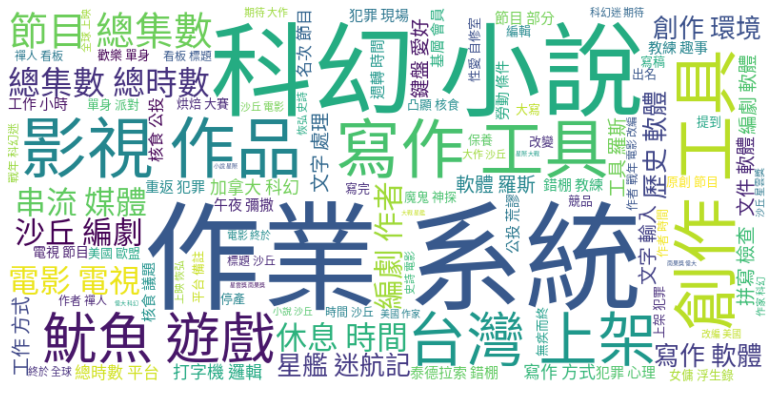

In [51]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
#stop_words_pos.extend(('哈利波特','魔法覺醒','緩緩','綻放','最近'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = './SourceHanSansTW-Regular.otf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

### 負面句子的用詞

In [52]:
# 篩時間區間
startdate = pd.to_datetime("2021-11-17").date()
enddate = pd.to_datetime("2021-11-21").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.375]

# 看一下負面句子都在討論甚麼
filter_sentiment[5:15]

,artUrl,sentence,artDate,artCat,sentimentValue
878,https://www.ptt.cc/bbs/EAseries/M.1637171434.A...,仰和病史是他個人非常私密的事，並不會公開討論，也沒有想開始和大眾分享的意思，,2021-11-17,EAseries,0.013510
883,https://www.ptt.cc/bbs/EAseries/M.1637171434.A...,報導進一步指出，節目統籌提姆米尼爾在內的多位製作人決定把他飾演,2021-11-17,EAseries,0.042602
884,https://www.ptt.cc/bbs/EAseries/M.1637171434.A...,角色的故事線寫為開放式結局，以期有一天問題解決後，能讓他回歸演出,2021-11-17,EAseries,0.006877
886,https://www.ptt.cc/bbs/EAseries/M.1637250116.A...,說到因為拒打疫苗所以退出劇組，這部影集也出現類似的情況，,2021-11-18,EAseries,0.039708
887,https://www.ptt.cc/bbs/EAseries/M.1637250116.A...,而且還有一個共通點這影集的版權與製作權益也是歸迪士尼所有,2021-11-18,EAseries,0.020523
889,https://www.ptt.cc/bbs/EAseries/M.1637250116.A...,///,2021-11-18,EAseries,0.250000
895,https://www.ptt.cc/bbs/EAseries/M.1637250116.A...,新鮮度，評分台灣觀眾很快能在平台上開追，但卻傳出第二季將失,2021-11-18,EAseries,0.284581
899,https://www.ptt.cc/bbs/EAseries/M.1637250116.A...,因為拍戲無法配戴口罩的演員，以及會和演員密切接觸的工作人員，消息人士指出,2021-11-18,EAseries,0.094654
900,https://www.ptt.cc/bbs/EAseries/M.1637250116.A...,，男星艾米里埃斯特維茲透過經紀人表示，無法保證能遵守規定，導致雙方陷入僵局,2021-11-18,EAseries,0.042280
903,https://www.ptt.cc/bbs/EAseries/M.1637250116.A...,也認真看待防疫政策，純粹是好萊塢常見的合約談不攏，加上五花八門的,2021-11-18,EAseries,0.186729


In [53]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='artUrl',how='left')
negative_words = negative_words[['artUrl','sentimentValue','word']]

In [54]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

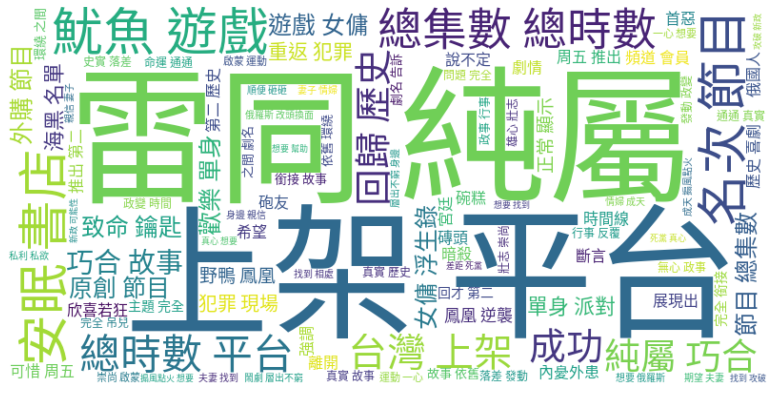

In [55]:
# 匯入自訂的 stop words
stop_words_neg = stop_words
#stop_words_neg.extend(('哈利波特','魔法覺醒','覺醒','玩'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = './SourceHanSansTW-Regular.otf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
                .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

##  6.TF-IDF
- TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度。
###  計算每篇文章的詞數

In [56]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

In [57]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(on my|JPTT|Sent from|媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))


In [58]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stop_words and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [59]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

Building prefix dict from C:\Users\Ling Chen\Documents\social_media_analysis\Disney_final\dict\dict.txt.big ...
Loading model from cache C:\Users\LINGCH~1\AppData\Local\Temp\jieba.u27f829edadc654c1cbff8855e4f1690a.cache
Loading model cost 1.173 seconds.
Prefix dict has been built successfully.


In [60]:
# 將word欄位展開
data = data.explode('word')

In [61]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,進入
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,九月
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,節目


In [62]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,10,6
1,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,100,2
2,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,11,2
3,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,114,2
4,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,12,3
...,...,...,...
40562,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,這部,2
40563,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,造景,1
40564,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,運鏡,1
40565,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,雷導,1


In [63]:
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,375
1,https://www.ptt.cc/bbs/EAseries/M.1633059283.A...,254
2,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,177
3,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,321
4,https://www.ptt.cc/bbs/EAseries/M.1633692858.A...,87
...,...,...
390,https://www.ptt.cc/bbs/movie/M.1638344172.A.99...,1130
391,https://www.ptt.cc/bbs/movie/M.1638458515.A.CD...,16
392,https://www.ptt.cc/bbs/movie/M.1638513875.A.98...,763
393,https://www.ptt.cc/bbs/movie/M.1638557464.A.63...,101


In [64]:
disney_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
disney_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,10,6,375
1,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,100,2,375
2,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,11,2,375
3,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,114,2,375
4,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,12,3,375
...,...,...,...,...
40562,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,這部,2,32
40563,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,造景,1,32
40564,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,運鏡,1,32
40565,https://www.ptt.cc/bbs/movie/M.1638580043.A.2C...,雷導,1,32


### 計算tf-idf值

In [65]:
#計算tf
disney_words_tf_idf = disney_words.assign(tf = disney_words.iloc[:,2]/disney_words.iloc[:,3])

In [66]:
# 計算每個詞彙出現在幾篇文章中
idf_df = disney_words.groupby(['word'],as_index=False).size()
disney_words_tf_idf = disney_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [67]:
#計算idf
disney_words_tf_idf = disney_words_tf_idf.assign(idf = disney_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

disney_words_tf_idf = disney_words_tf_idf.drop(labels=['size'],axis=1)

In [68]:
#計算tf*idf
disney_words_tf_idf =disney_words_tf_idf.assign(tf_idf = disney_words_tf_idf.iloc[:,4]*disney_words_tf_idf.iloc[:,5])

In [69]:
disney_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,10,6,375,0.016000,0.840722,0.013452
1,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,100,2,375,0.005333,1.366148,0.007286
2,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,11,2,375,0.005333,0.889027,0.004741
3,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,114,2,375,0.005333,2.596597,0.013849
4,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,12,3,375,0.008000,0.933839,0.007471


In [70]:
# 選出每篇文章，tf-idf值最大的五個詞
group = disney_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [71]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                                   
https://www.ptt.cc/bbs/EAseries/M.1633052780.A.... 69   Netflix  0.060047
                                                   183       節目  0.035823
                                                   99        上架  0.022999
                                                   165       時數  0.021898
                                                   225       點擊  0.021275
https://www.ptt.cc/bbs/EAseries/M.1633059283.A.... 399       試映  0.051114
                                                   417       預定  0.035796
                                                   237      CBS  0.031410
                                                   266      McG  0.030668
                                                   273      Nix  0.030668
https://www.ptt.cc/bbs/EAseries/M.1633661959.A.... 543      記者會  0.038271
                                                   456       價格  0.026359
                                                   506       星光  0.023949
                                                   489       已知  0.022537
                                                   447       一年  0.021600

In [72]:
# 從每篇文章挑選出tf-idf最大的十個詞
(disney_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
2165,永恆,14
333,Netflix,13
650,中國,12
1559,尚氣,11
2513,節目,11
594,上架,9
1122,台灣,9
892,八卦,8
2245,漫威,7
3178,鷹眼,7


## 7.Bigram
- 透過結巴斷詞與N-gram幫助建立字典。
- Bigram可用來計算字詞組合出現次數，並且用來預測字詞。

In [73]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stop_words and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [74]:
disney_bigram = MetaData.copy()
disney_bigram["word"] = disney_bigram.sentence.apply(bigram_getToken)

In [75]:
disney_bigram = disney_bigram.explode('word')
disney_bigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,進入 九月
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,九月 節目
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,節目 增多


In [76]:
# 計算每個組合出現的次數
disney_bigram_count = disney_bigram.groupby(["word"],as_index=False).size()

In [77]:
# 清除包數字的bigram組合
wb_filter = list(disney_bigram_count["word"].apply(lambda x: True if not re.search("[0-9]",x) else False))
disney_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
30769,漫威 電影,58
25953,新聞 網址,49
21797,復仇者 聯盟,35
47252,魷魚 遊戲,33
12944,十環 傳奇,32
19600,尚氣 十環,32
3764,Netflix 台灣,30
7558,串流 平台,29
42686,這部 電影,27
45302,雷神 索爾,25


In [78]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stop_words and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [79]:
disney_trigram = MetaData.copy()
disney_trigram["word"] = disney_trigram.sentence.apply(trigram_getToken)
disney_trigram = disney_trigram.explode('word')
disney_trigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,進入 九月 節目
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,九月 節目 增多
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,節目 增多 每周


In [80]:
# 計算每個組合出現的次數
disney_trigram_count = disney_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
wb_filter = list(disney_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
disney_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
21537,尚氣 十環 傳奇,32
33470,漫威 電影 宇宙,23
38688,節目 總集 時數,21
15995,名次 節目 總集,21
39967,總集 時數 平台,20
7240,上映 上映 日為,14
28999,時數 平台 備註,13
34787,獵鷹 酷寒 戰士,13
17256,圖片 來源 蘋果,12
10655,來源 蘋果 新聞網,12


In [81]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [82]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [83]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [84]:
text = 'Disney'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 提供, probability: 0.0319
next word: 台灣, probability: 0.0266
next word: 上線, probability: 0.0266
next word: Original, probability: 0.0239
next word: 上架, probability: 0.0186


In [85]:
text = '漫威'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 電影, probability: 0.222
next word: 影業, probability: 0.0766
next word: 星際大戰, probability: 0.046
next word: 宇宙, probability: 0.0383
next word: 系列, probability: 0.0345


In [86]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stop_words and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [87]:
disney_bigram2 = MetaData.copy()
disney_bigram2["word"] = disney_bigram2.sentence.apply(bigram_getToken_dict)

In [88]:
disney_bigram2 = disney_bigram2.explode('word')
disney_bigram2.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,進入 九月
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,九月 節目
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...,節目 增多


In [89]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('漫威', '電影'), 58),
 (('新聞', '網址'), 49),
 (('復仇者', '聯盟'), 35),
 (('魷魚', '遊戲'), 33),
 (('尚氣', '十環'), 32)]

### 7.1 繪製字詞關聯圖
使用Bigram統計結果繪製字詞關聯圖。

In [90]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [91]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.1 for w in  G.edges(data=True)]

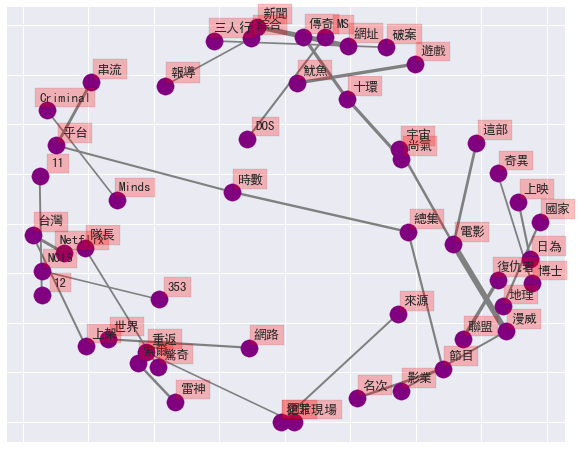

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示    
plt.show()

從關聯圖中，我們可以看到PTT的網友們主要提到的都是一些影視作品的名稱，或是角色人物，同時也有出現了一些平台等相關的關聯字詞。

In [93]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [94]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [95]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count[word_count["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count[word_count["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count[word_count["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count[word_count["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [96]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [97]:
bigram_df[5:10]

,word,word2,n,cor
5,十環,傳奇,32,0.843191
6,Netflix,台灣,30,0.088012
7,串流,平台,29,0.592091
8,這部,電影,27,0.281846
9,名次,節目,25,0.532615


###  和 Disney, 漫威 相關性最高的 15 個詞彙

In [98]:
c_sum = bigram_df[(bigram_df["word"]=="Disney")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="漫威")].sort_values(by=['cor'], ascending = False).head(15)

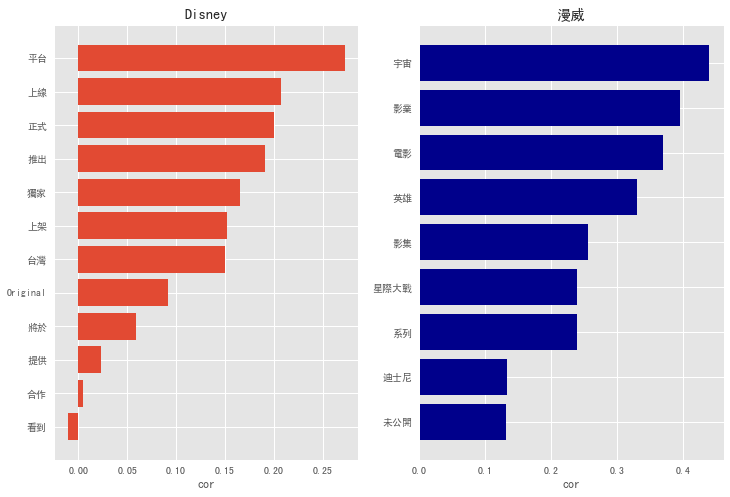

In [99]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('Disney')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('漫威')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

plt.show()

In [100]:
bigram_df[bigram_df["cor"]>0.4]

,word,word2,n,cor
1,新聞,網址,49,0.861498
2,復仇者,聯盟,35,0.717328
3,魷魚,遊戲,33,0.735498
4,尚氣,十環,32,0.798591
5,十環,傳奇,32,0.843191
...,...,...,...,...
493,寇弟,頂級,4,0.864920
496,火速,救援,4,0.511777
497,救援,前線,4,0.511777
498,克蒙德,巴爾,4,1.000000


### 使用詞彙關係圖畫出相關性大於0.4的組合

In [101]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [102]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

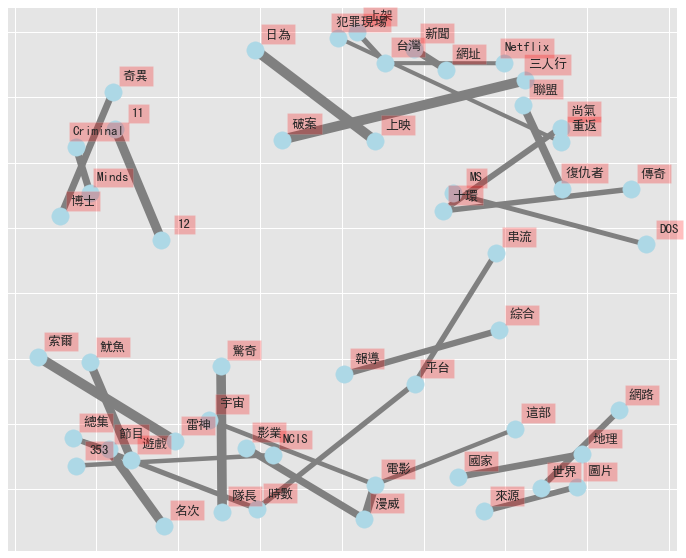

In [103]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示    
plt.show()

### 計算文章相似度

In [104]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)

In [105]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

,00,000,000m,001,007,01,017,02,020,021,...,龍斑,龍珠,龍背,龍要,龍間,龍頭老大,龍頭股,龐大,龐德,龜派
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
transformer = TfidfTransformer()  
print(transformer) 
#將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()


,00,000,000m,001,007,01,017,02,020,021,...,龍斑,龍珠,龍背,龍要,龍間,龍頭老大,龍頭股,龐大,龐德,龜派
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

In [108]:
print(tfidf.toarray()[30])
cos_df = cosine_similarity(tfidf.toarray()[30])

[0.        0.        0.        ... 0.2164813 0.        0.       ]


In [109]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle
30,1.000000,[閒聊]Disney+推薦影集
182,0.231154,[問卦]訂閱Disney+只為了看空中浩劫很怪嗎？
361,0.157046,Re:[請益]3D動畫成本有比2D動畫低嗎
43,0.143252,[討論]今年漫威影集策略，目前算是成功嗎？
184,0.135317,Re:[問卦]Disney+有什麼能看的?
18,0.129521,Re:[新聞]Disney+明日台灣上線！官方公開第一天「
185,0.127351,[問卦]漫威和星戰要從哪部開始看？
76,0.121314,[新聞]Disney+登台｜訂閱價每月270元 同步支
340,0.115491,Re:[討論]Disney+正式上線，看起來
362,0.110919,Re:[請益]終局之戰後漫威影集電影詢問


## 8.字詞分類

In [110]:
disney = MetaData.copy()
disney.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運,2021/10/01,01:46:17,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,ariachiang,EAseries,0,0,0,進入九月，隨著節目量的增多，可能每周都會有一兩個新節目出現在前10之列。\n但Netflix...


In [111]:
# 看看有幾篇文章
print(f"number of posts: {disney.shape[0]}")

number of posts: 395


In [112]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

In [113]:
# 篩選需要的欄位
disney['content'] = disney['artTitle'] + disney['sentence']
disney = disney.dropna() #去掉空白欄位
data = disney[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

<ipython-input-113-3ef5618ff7ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開


,sentence,artUrl,document
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運進入九月，隨著節目量的增多，可能每周都會有一...,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,0
0,但Netflix的老闆有說後面(明年初以後)的檔期真受到疫情停工影響，或許偶爾會出現包括,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,1
0,新作在內的串流節目出現青黃不接的情況。,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,2


In [114]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 10294


In [115]:
def load_stop_words(path):
    with open(path, encoding = 'UTF-8') as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
 #   sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [116]:
# 這裡會跑比較久
stop_path = 'dict/stopwords.txt'
user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)

,sentence,artUrl,document,clean_txt
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運進入九月，隨著節目量的增多，可能每周都會有一...,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,0,收視 串流 第一周 點擊 鶴立 雞群 超越 命運 進入 九月 節目 增多 每周 一兩個 節目...
0,但Netflix的老闆有說後面(明年初以後)的檔期真受到疫情停工影響，或許偶爾會出現包括,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,1,Netflix 老闆 後面 明年初 以後 檔期 疫情 停工 影響 出現 包括
0,新作在內的串流節目出現青黃不接的情況。,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,2,新作 在內 串流 節目 出現 青黃不接 情況
0,(希望不會因為要趕上期程就隨便了),https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,3,希望 趕上 期程 隨便
0,在原創榜的部分，本周有新作、推出新季及因為時機而進入前10名的節目。,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,4,原創 部分 本周 新作 推出 新季 時機 進入 10 節目


In [117]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

<ipython-input-117-6a94f2662065>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list


,document,word
0,0,收視
1,0,串流
2,0,第一周
3,0,點擊
4,0,鶴立


In [118]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 16455


In [119]:
#去除只有''的
count=0
for i in range(len(token_df)):
  #if token_df['artUrl'][i]=='https://www.ptt.cc/bbs/Gossiping/M.1636615799.A.44B.html':
    if token_df['word'][i]==str(''):
      token_df=token_df.drop(index=i)
      # print(token_df['artUrl'][i])
      # print(token_df['document'][i])    
      count=count+1
print(count)

746


### 8.1 計算情緒分數，將正負面文章分類

情緒字典：正負向字典採用NTUSD(台大)情緒字典。

In [120]:
def load_senti():
    filepath = ['ntusd-negative','ntusd-positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split("\n"),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

In [121]:
# 獲得情緒字典
data_liwc = load_senti() 

# 新增的負面詞
# neg_added = ["不同意"]
# for w in neg_added:
#     data_liwc.loc[-1] = [w, "ntusd-negative"]
#     data_liwc.index = data_liwc.index + 1
#     data_liwc = data_liwc.sort_index()
data_liwc.head(5)

,word,sentiments
0,幹,ntusd-negative
1,一下子爆發,ntusd-negative
2,一下子爆發的一連串,ntusd-negative
3,一巴掌,ntusd-negative
4,一再,ntusd-negative


In [122]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['ntusd-positive'] >= senti_count['ntusd-negative'], 'pos','neg')
senti_count.head(5)

,document,ntusd-negative,ntusd-positive,label
0,3,2.0,2.0,pos
1,4,0.0,1.0,pos
2,5,1.0,0.0,neg
3,13,1.0,0.0,neg
4,17,1.0,0.0,neg


In [123]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,sentence,artUrl,document,clean_txt,label
0,[收視]串流--9月第一周，點擊鶴立雞群超越命運進入九月，隨著節目量的增多，可能每周都會有一...,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,0,收視 串流 第一周 點擊 鶴立 雞群 超越 命運 進入 九月 節目 增多 每周 一兩個 節目...,neu
1,但Netflix的老闆有說後面(明年初以後)的檔期真受到疫情停工影響，或許偶爾會出現包括,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,1,Netflix 老闆 後面 明年初 以後 檔期 疫情 停工 影響 出現 包括,neu
2,新作在內的串流節目出現青黃不接的情況。,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,2,新作 在內 串流 節目 出現 青黃不接 情況,neu
3,(希望不會因為要趕上期程就隨便了),https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,3,希望 趕上 期程 隨便,pos
4,在原創榜的部分，本周有新作、推出新季及因為時機而進入前10名的節目。,https://www.ptt.cc/bbs/EAseries/M.1633052780.A...,4,原創 部分 本周 新作 推出 新季 時機 進入 10 節目,pos


In [124]:
print(f"total posts: {len(data_senti.artUrl.unique())}")
print(f"total sentences: {len(data_senti.document.unique())}")

total posts: 395
total sentences: 10294


In [125]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

,label,word,size
22626,pos,電影,213
19933,pos,永恆,137
15542,pos,Disney+,123
20736,pos,知道,122
20154,pos,漫威,115


### 選出正面、負面文章最高的20個字

In [126]:
# 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

,label,word,size
4243,neg,票房,25
4463,neg,網路,27
5092,neg,超過,27
3159,neg,新聞,29
1714,neg,問卦,29


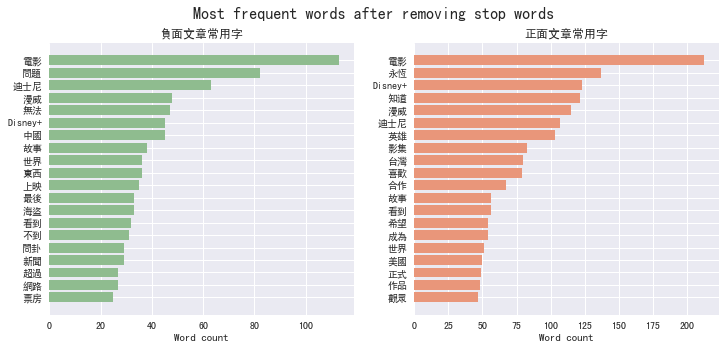

In [127]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()

滿有趣的是，不管是正面文章還是負面文章，最常用的前五個字詞有兩個是重複的，分別是**<font>「電影」和「漫威」</font>**。<br>
因為這邊在討論的是和串流影音相關的內容，所以有電影出現在這邊並不意外，不過漫威出現在這邊，或許可以代表著觀眾對於漫威的影集是評價兩極的。

### 將資料切成訓練集與測試集
根據7:3的比例切分資料集

In [128]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [129]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
neu    59.801826
pos    24.596853
neg    15.601321
Name: label, dtype: float64

train percentage :
neu    59.805690
pos    24.594032
neg    15.600278
Name: label, dtype: float64

test percentage :
neu    59.792813
pos    24.603432
neg    15.603755
Name: label, dtype: float64


## 9.將文章轉為 DTM
+ 模型訓練: logistic regression + cv tokenizer

In [130]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000,min_df = 10) # , ngram_range=(1,2)

# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100) # , ngram_range=(1,2)

In [131]:
corpus = dtf_train["clean_txt"]

+ 過濾詞頻比較

In [132]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

In [133]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 
X_train

without term cut off: posts 7205 words: 10000 (10000)
with term cut off: posts 7205 words: 721 (721)


<7205x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 37221 stored elements in Compressed Sparse Row format>

In [134]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [135]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.83
Auc: 0.91
Detail:
              precision    recall  f1-score   support

         neg       0.83      0.43      0.57       482
         neu       0.81      0.99      0.89      1847
         pos       0.90      0.69      0.78       760

    accuracy                           0.83      3089
   macro avg       0.85      0.70      0.75      3089
weighted avg       0.83      0.83      0.81      3089



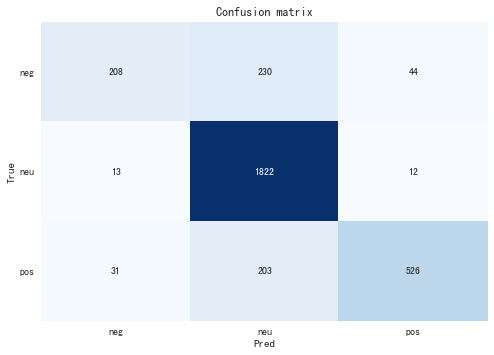

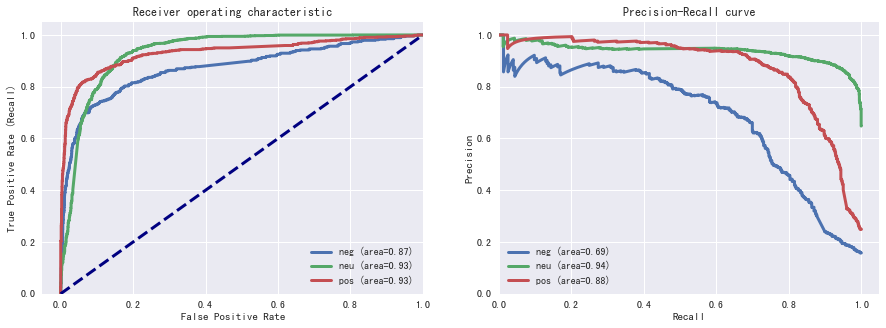

In [136]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [137]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

C:\Users\Ling Chen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.78
Auc: 0.81
Detail:
              precision    recall  f1-score   support

         neg       0.68      0.32      0.44       482
         neu       0.77      0.97      0.86      1847
         pos       0.86      0.61      0.71       760

    accuracy                           0.78      3089
   macro avg       0.77      0.63      0.67      3089
weighted avg       0.78      0.78      0.76      3089



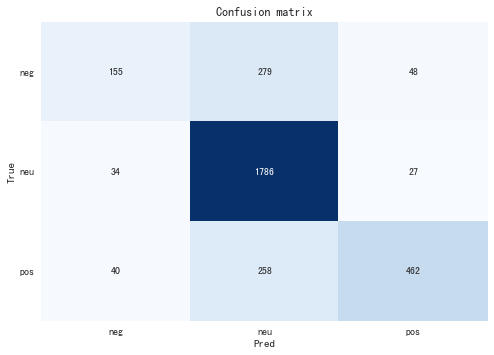

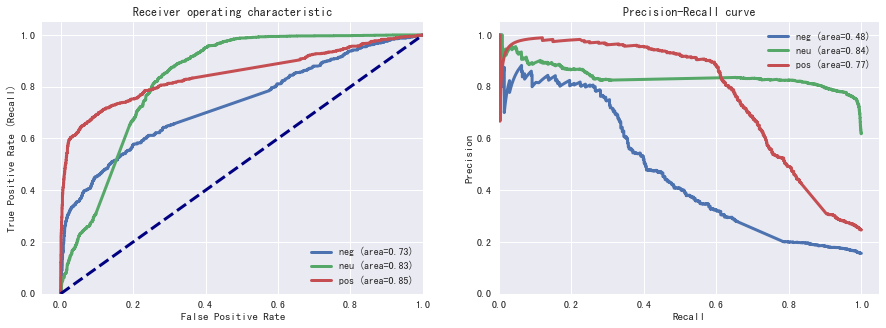

In [138]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### 9.1 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數。

In [139]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [140]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

#### step 1 定義 vectorizer

In [141]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

#### step 2 定義 classifier

In [142]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

#### step 3 定義測試和訓練資料集

In [143]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [144]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

## 10.比較不同模型和資料組合的訓練結果

### 10.1 Model Building : logistic regression 
logistic regression 原本是用來做二元分類的，如果要多元分類需要另外指定
+ 預設是預測二元分布(binomial probability)的機率，需要改為多元分布(multinomial probability)

model type: CV + logistic regression
time costing: 0.8428874015808105
Accuracy: 0.83
Auc: 0.91
Detail:
              precision    recall  f1-score   support

         neg       0.83      0.43      0.57       482
         neu       0.81      0.99      0.89      1847
         pos       0.90      0.69      0.78       760

    accuracy                           0.83      3089
   macro avg       0.85      0.70      0.75      3089
weighted avg       0.83      0.83      0.81      3089



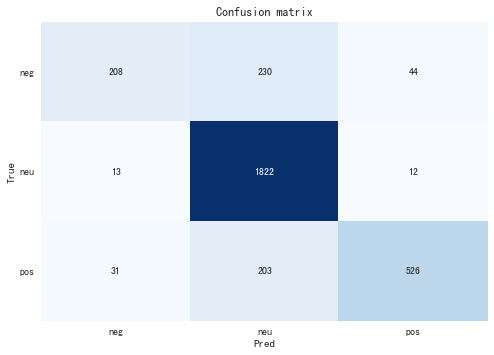

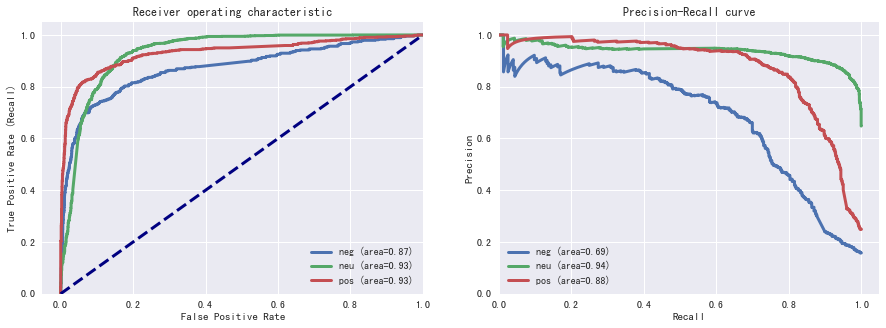

In [145]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression
time costing: 0.6043853759765625
Accuracy: 0.78
Auc: 0.91
Detail:
              precision    recall  f1-score   support

         neg       0.86      0.28      0.43       482
         neu       0.75      0.99      0.86      1847
         pos       0.91      0.60      0.72       760

    accuracy                           0.78      3089
   macro avg       0.84      0.62      0.67      3089
weighted avg       0.81      0.78      0.76      3089



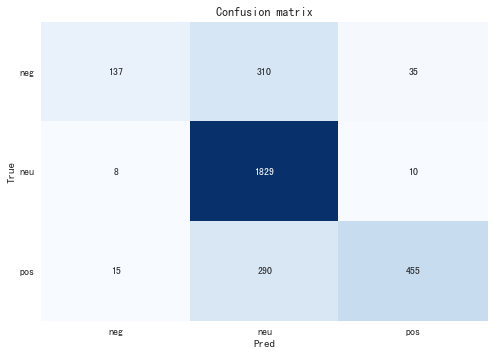

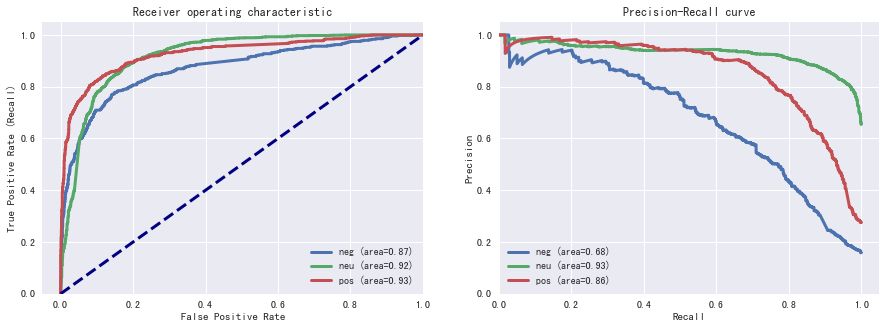

In [146]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 10.2 Model Building : SVC

model type: CV + SVC
time costing: 20.70389199256897
Accuracy: 0.79
Auc: 0.9
Detail:
              precision    recall  f1-score   support

         neg       0.91      0.26      0.41       482
         neu       0.78      0.98      0.87      1847
         pos       0.81      0.67      0.74       760

    accuracy                           0.79      3089
   macro avg       0.84      0.64      0.67      3089
weighted avg       0.81      0.79      0.76      3089



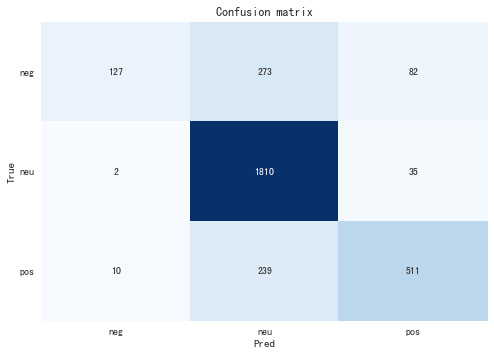

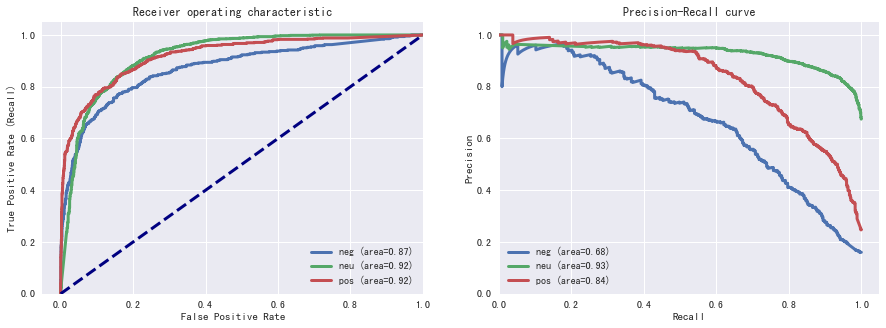

In [147]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 23.587581634521484
Accuracy: 0.78
Auc: 0.91
Detail:
              precision    recall  f1-score   support

         neg       0.89      0.29      0.44       482
         neu       0.74      0.99      0.85      1847
         pos       0.90      0.57      0.70       760

    accuracy                           0.78      3089
   macro avg       0.85      0.62      0.66      3089
weighted avg       0.81      0.78      0.75      3089



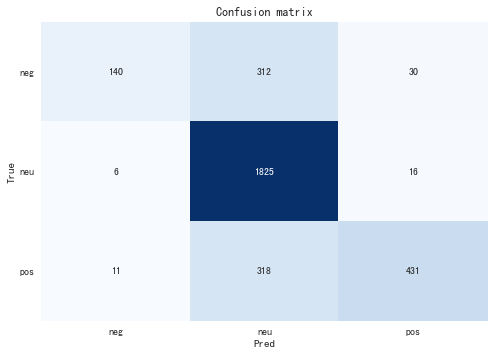

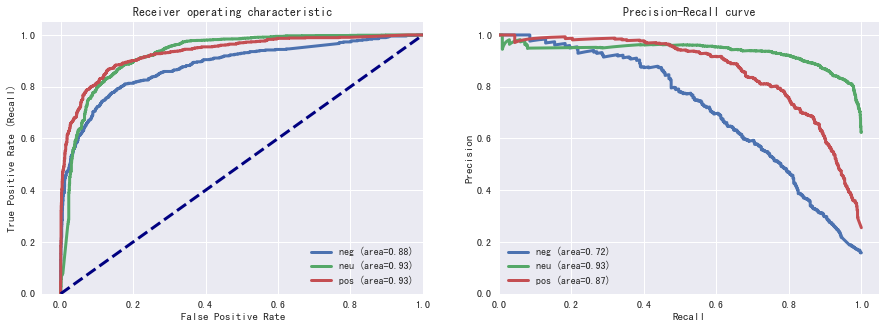

In [148]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 10.3 Model Building : Random Forest

model type: CV + RandomForest
time costing: 5.9132981300354
Accuracy: 0.86
Auc: 0.93
Detail:
              precision    recall  f1-score   support

         neg       0.86      0.52      0.65       482
         neu       0.85      0.99      0.91      1847
         pos       0.92      0.76      0.83       760

    accuracy                           0.86      3089
   macro avg       0.88      0.76      0.80      3089
weighted avg       0.87      0.86      0.85      3089



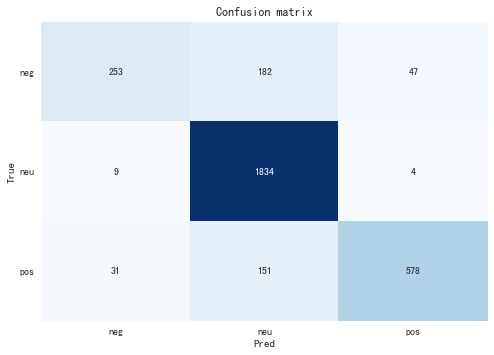

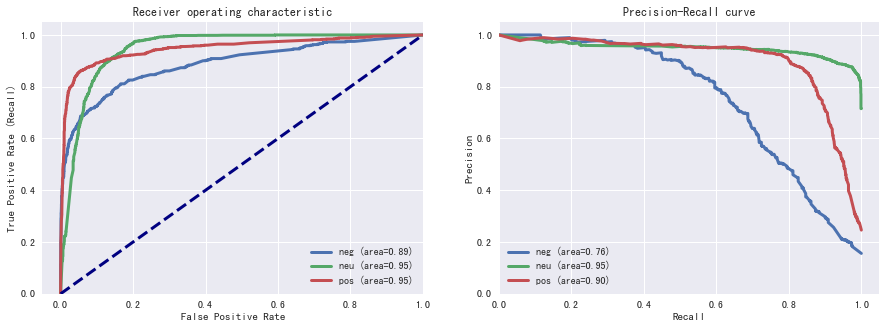

In [149]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 5.891742944717407
Accuracy: 0.86
Auc: 0.93
Detail:
              precision    recall  f1-score   support

         neg       0.89      0.52      0.65       482
         neu       0.84      0.99      0.91      1847
         pos       0.92      0.76      0.83       760

    accuracy                           0.86      3089
   macro avg       0.88      0.75      0.80      3089
weighted avg       0.87      0.86      0.85      3089



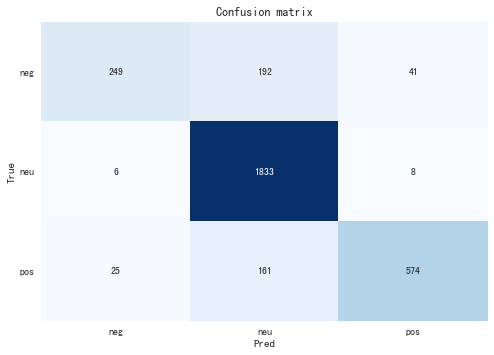

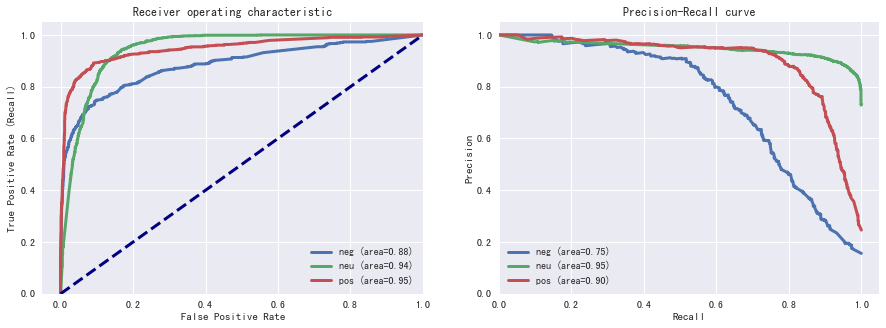

In [150]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 10.4 預測結果探索

In [151]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
4,CV + RandomForest,0.862739,0.927387
5,TF-IDF + RandomForest,0.859825,0.925363
0,CV + logistic regression,0.827452,0.912599
2,CV + SVC,0.792489,0.903598
1,TF-IDF + logistic regression,0.783749,0.906671
3,TF-IDF + SVC,0.775656,0.913547


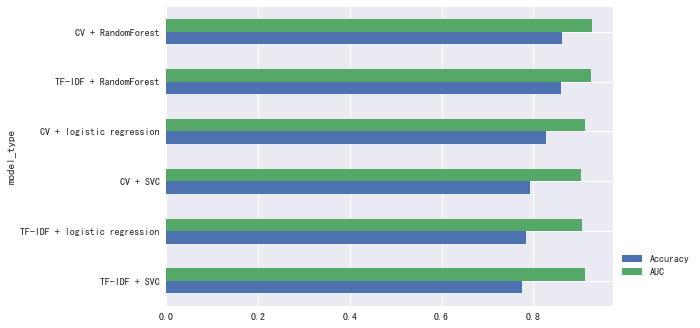

In [152]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(1,0.2))

準確率最好的是CV + logistic regression，其次則是TF-IDF + RandomForest。

#### 10.4.1 各字詞特徵的estimate係數

In [153]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [154]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

,neg,neu,pos
00,-0.321352,-0.165591,-0.028551
000,-0.045537,0.302955,1.445926
000m,0.159887,-0.025037,-0.031575
001,0.213244,0.126331,-0.028511
007,0.053456,-0.075889,0.020005


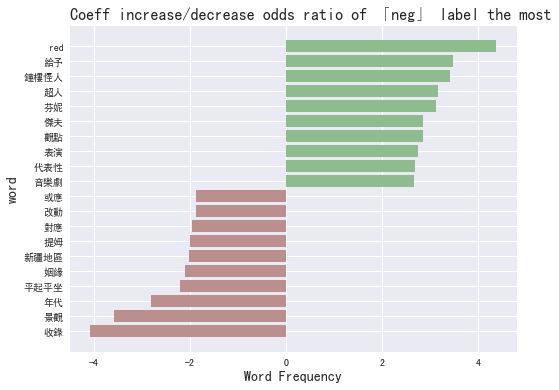

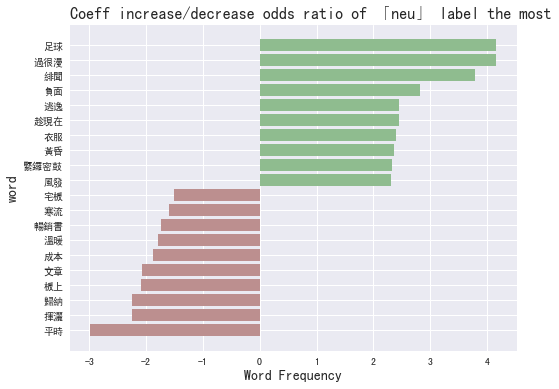

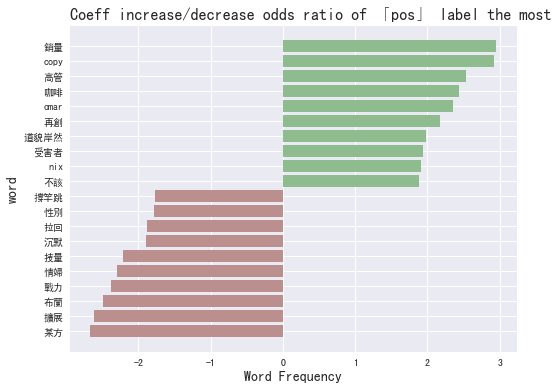

In [155]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

看一下含特定關鍵字的句子

In [156]:
keyword_list = ['訂閱','魔境','資本家'] 
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(10)

,document,sentence,artUrl,label
121,121,記者會由Sandy（吳姍儒）主持，記者會上也宣布台灣訂閱價格，為一個月270元、一年27,https://www.ptt.cc/bbs/EAseries/M.1633661959.A...,neu
159,159,在台上市記者會，公布訂閱價格為一個月270元、一年2790年。,https://www.ptt.cc/bbs/EAseries/M.1633684291.A...,neu
379,379,備受期待的影音串流服務 Disney+ 將在 11/12 正式上線，訂閱費用為每月新台幣 2...,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,pos
390,390,訂閱用戶還可以利用 GroupWatch 功能，與家人和朋友們同步觀賞,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,neg
392,392,訂閱用戶能在各種行動裝置或是聯網電視設備上隨時隨地享受 Disney+ 的體驗，包括,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,pos
407,407,，訂閱用戶也可以期待欣賞到許多由亞太地區優秀的創作者所帶來的原創故事。,https://www.ptt.cc/bbs/EAseries/M.1634291453.A...,pos
868,868,官方公開第一天「訂閱完之後發現畫質不對，,https://www.ptt.cc/bbs/EAseries/M.1636658604.A...,pos
899,899,分享給還沒訂閱過的人,https://www.ptt.cc/bbs/EAseries/M.1636692339.A...,neu
958,958,[閒聊]Disney+推薦影集剛訂閱Disney+ 除了龐大的漫威電影跟皮克斯動畫庫外,https://www.ptt.cc/bbs/EAseries/M.1636731945.A...,pos
1884,1884,[討論]Disney＋的訂閱方式明年漫威還有7部影集要上，期待啊！,https://www.ptt.cc/bbs/EAseries/M.1638502540.A...,pos


#### 10.4.2 查看分類錯誤的句子

In [157]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 186
neg label predicted wrong: 233
neu label predicted wrong: 14


<ipython-input-157-58a77aec66f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test['predict'] = pred


In [158]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
3570,駐上海國際商業和諮詢公司FAO Global管理顧問卡梅倫‧約翰遜（Cameron John...,https://www.ptt.cc/bbs/Gossiping/M.1636470886....,pos,neu
7491,英勇犧牲的，只有小勞勃道尼飾演的「鋼鐵人」及史嘉蕾喬韓森演出的「黑寡婦」。,https://www.ptt.cc/bbs/movie/M.1635954120.A.2E...,pos,neu
3356,所以來問問大家，影評要掌握哪些重點,https://www.ptt.cc/bbs/Gossiping/M.1636357372....,pos,neu
6049,不然感覺女主好像只是去露個面，兩人就從此安全了。,https://www.ptt.cc/bbs/movie/M.1634218031.A.31...,pos,neu
9671,Re:[新聞]雷利史考特：超級英雄電影無聊又沒營養先不論近年各名導演終於忍不住說出內心真話…,https://www.ptt.cc/bbs/movie/M.1637696180.A.83...,pos,neg


In [159]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
4245,地獄廚神（？,https://www.ptt.cc/bbs/Gossiping/M.1636778988....,neg,neu
7091,拍出來的片也都很沈重，所以當然想看的不多,https://www.ptt.cc/bbs/movie/M.1635643475.A.CF...,neg,neu
8087,將在片中飾演邪惡的「壞皇后」。,https://www.ptt.cc/bbs/movie/M.1636093633.A.39...,neg,neu
5529,「那中國人又怎麼可能一邊被這麼侮辱，」《環球時報》的評論文章問道，「一邊還讓你,https://www.ptt.cc/bbs/movie/M.1633324148.A.67...,neg,neu
8205,庫伊拉的兩個跟班以前的印象就是那種闖禍型笨蛋,https://www.ptt.cc/bbs/movie/M.1636289201.A.F6...,neg,neu


In [160]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
6972,來》，狼的孩子對已成父母的我而言是哭到不行,https://www.ptt.cc/bbs/movie/M.1635478033.A.1A...,neu,pos
4520,搭配XGPU玩起來真的還蠻爽的啊,https://www.ptt.cc/bbs/Gossiping/M.1636946916....,neu,pos
9089,（中央社記者王寶兒台北18日電）已故漫畫家葉宏甲經典作「諸葛四郎」是台灣3年級生,https://www.ptt.cc/bbs/movie/M.1637293610.A.8D...,neu,pos
9119,劇裡面講得是腦內住著五種情緒,https://www.ptt.cc/bbs/movie/M.1637308184.A.B7...,neu,neg
6845,向十年，而艾德華諾頓這位曾獲金獎提名的男星，也因與漫威電影工作室上對於浩克電影,https://www.ptt.cc/bbs/movie/M.1635234902.A.E2...,neu,pos


#### 10.4.3 比較不同模型的ROC
ROC 只適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果。

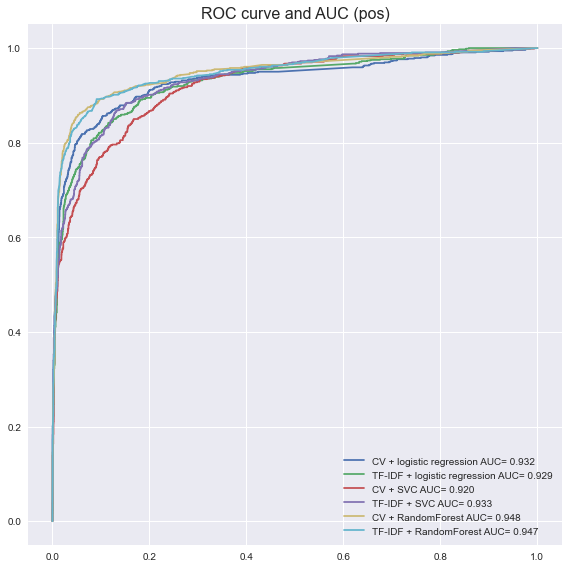

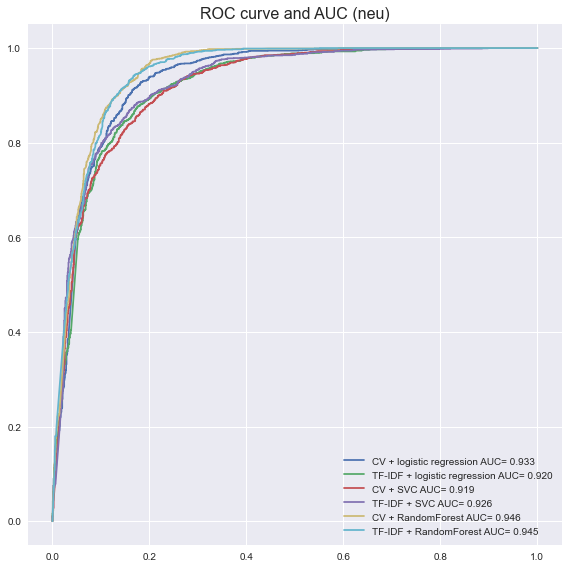

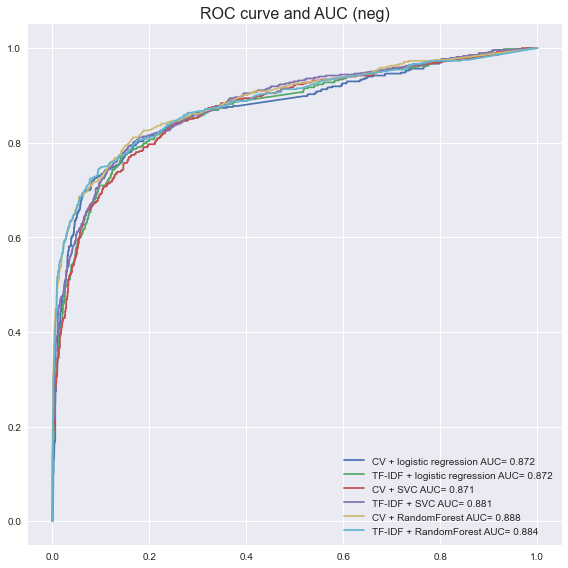

In [161]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

## 結論
1. 各情緒的字詞分佈有什麼不同，代表字詞有哪些？
    + 用詞頻探索發現，可以看到正面、負面文章最常用的前五個字詞有兩個是重複的，分別是「電影」和「漫威」。
    
2. 此資料集用什麼樣的模型預測，準確率會較高？
    + 模型在三種情緒的AUC指標都相差不大，整體而言，正面情緒和中立情緒都有90%以上的表現，而負面情緒則是介於80~90%。
    + 在AUC面向，整體而言，CV + Random Forest 的表現都是最好。   